# Sentinel 2A Plastic Waste Exploration
A starting point for exploring multispectral data from Sentinel 2A for TPA sites in Indonesia.

## Explorations:
### [1. Patch Visualization](#Exploration-1)
For each known plastic waste site, define a rect centered on the known coordinates. Additionally, define an adjacent rect as a control reference. For every rect, extract an image patch from every Sentinel image band and visualize. 

### [2. Patch Comparison](#Exploration-2)
Using the extracted patches from Exploration #1, compare mean/median reflectance across bands between patches from waste sites and their corresponding control sites. In addition to site-by-site comparisons, aggregate these statistics across all sites to assess the trends.

### [3. Temporal Monitoring](#Exploration-3)
At each site, visualize how mean/median reflectance changes over time for each Sentinel imaging band.

### [4. Spectral Signal Clustering](#Exploration-4)
Compile the mean/median values computed at each site and time point in Exploration #3 into a multi-dimensional vector. Compress the dimensionality of the vectors using PCA or tSNE, and visualize whether waste and control sites form separable clusters.

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from tqdm.notebook import tqdm
from tqdm.contrib.concurrent import thread_map
from functools import partial
import json
import os
from datetime import datetime
from sklearn.decomposition import PCA

import ee
import geemap
import geemap.eefolium

import folium

%load_ext autoreload
%autoreload 2

In [2]:
ee.Authenticate()

In [3]:
ee.Initialize()

### Sentinel 2 Cloud Filtering
Uses the new S2 Cloud Probability dataset. [Details on the algorithm](https://medium.com/google-earth/more-accurate-and-flexible-cloud-masking-for-sentinel-2-images-766897a9ba5f)

In [4]:
def get_s2_sr_cld_col(aoi, start_date, end_date):
    """
    Creates an ImageCollection for a region and time period.
    ImageCollection is prefiltered by the QA60 cloud mask band
    Prefiltering percentage specified by global `CLOUD_FILTER` variable
    """
    # Import and filter S2 SR.
    s2_sr_col = (ee.ImageCollection('COPERNICUS/S2_SR')
        .filterBounds(aoi)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER)))

    # Import and filter s2cloudless.
    s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(aoi)
        .filterDate(start_date, end_date))

    # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
    return ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_col,
        'secondary': s2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))

def add_cloud_bands(img):
    """
    From the s2_cloud_probability dataset, return an image with
    cloud probabilities below the global `CLD_PRB_THRESH` variable
    """
    # Get s2cloudless image, subset the probability band.
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

    # Condition s2cloudless by the probability threshold value.
    is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

    # Add the cloud probability layer and cloud mask as image bands.
    return img.addBands(ee.Image([cld_prb, is_cloud]))

def add_shadow_bands(img):
    """
    Isolate cloud shadows over land
    Cloud shadow thresholds are given by the global `NIR_DRK_THRESH` variable
    CK Note: I don't think this algorithm works over water
    """
    # Identify water pixels from the SCL band.
    not_water = img.select('SCL').neq(6)

    # Identify dark NIR pixels that are not water (potential cloud shadow pixels).
    SR_BAND_SCALE = 1e4
    dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')

    # Determine the direction to project cloud shadow from clouds (assumes UTM projection).
    shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));

    # Project shadows from clouds for the distance specified by the CLD_PRJ_DIST input.
    cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
        .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
        .select('distance')
        .mask()
        .rename('cloud_transform'))

    # Identify the intersection of dark pixels with cloud shadow projection.
    shadows = cld_proj.multiply(dark_pixels).rename('shadows')

    # Add dark pixels, cloud projection, and identified shadows as image bands.
    return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))

def add_cld_shdw_mask(img):
    """
    Create a mask based on the cloud and cloud shadow images
    """
    # Add cloud component bands.
    img_cloud = add_cloud_bands(img)

    # Add cloud shadow component bands.
    img_cloud_shadow = add_shadow_bands(img_cloud)

    # Combine cloud and shadow mask, set cloud and shadow as value 1, else 0.
    is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)

    # Remove small cloud-shadow patches and dilate remaining pixels by BUFFER input.
    # 20 m scale is for speed, and assumes clouds don't require 10 m precision.
    is_cld_shdw = (is_cld_shdw.focal_min(2).focal_max(BUFFER*2/20)
        .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
        .rename('cloudmask'))

    # Add the final cloud-shadow mask to the image.
    return img_cloud_shadow.addBands(is_cld_shdw)

def apply_cld_shdw_mask(img):
    """
    Apply the cloud mask to the all Sentinel bands beginning with `B`
    """
    # Subset the cloudmask band and invert it so clouds/shadow are 0, else 1.
    not_cld_shdw = img.select('cloudmask').Not()

    # Subset reflectance bands and update their masks, return the result.
    return img.select('B.*').updateMask(not_cld_shdw)

## Setup Parameters

In [5]:
DATA_DIR = '../data'

In [6]:
CLOUD_FILTER = 30
CLD_PRB_THRESH = 60
NIR_DRK_THRESH = 0.15
CLD_PRJ_DIST = 1
BUFFER = 50
DATASET = 'COPERNICUS/S2_SR'

In [7]:
# Load tpa_points dataset and create a list of coordinates for the known sites

with open(os.path.join(DATA_DIR, 'tpa_points.json')) as f:
  tpa_points = json.load(f)
  f.close()

tpa_sites = pd.DataFrame({
    'name': [site['properties']['Name'] for site in tpa_points['features']],
    'lon': [site['geometry']['coordinates'][0] for site in tpa_points['features']],
    'lat': [site['geometry']['coordinates'][1] for site in tpa_points['features']],
    'area': [site['properties']['Surface_Ha'] for site in tpa_points['features']],
    'daily_volume': [site['properties']['TOT_Kg/Day'] for site in tpa_points['features']],
    'coords': [site['geometry']['coordinates'] for site in tpa_points['features']]
})


display(tpa_sites)


,name,lon,lat,area,daily_volume,coords
0,TPA Jungut Batu,115.459414,-8.670958,1.20,NaN,"[115.45941439485306, -8.670958330781342]"
1,TPA Biaung,115.498017,-8.679930,1.85,9433.0,"[115.49801683267276, -8.679930042100876]"
2,TPA Sente,115.454460,-8.530372,1.00,43219.0,"[115.45446033358267, -8.530371792768301]"
3,TPA Regional Bangli,115.367927,-8.353542,0.99,47350.0,"[115.3679270185395, -8.353541681392851]"
4,TPA Peh,114.583295,-8.327938,2.00,38130.0,"[114.58329467897306, -8.327937523143966]"
5,TPA Temesi,115.350242,-8.562121,1.05,209560.0,"[115.35024222376158, -8.562120592268835]"
6,TPA Bengkala,115.170153,-8.091409,0.35,125350.0,"[115.17015250951603, -8.091408966864984]"
7,TPA Bebandem,115.564212,-8.403448,0.77,43860.0,"[115.56421218781115, -8.403447940383018]"
8,TPA Mandung,115.095133,-8.529953,2.50,64580.0,"[115.09513259339289, -8.529952637269275]"
9,TPA Regional Suwung,115.221107,-8.720775,4.52,1358533.0,"[115.22110665725374, -8.720775407750443]"


In [8]:
# Sentinel 2 band descriptions
band_descriptions = {
    'B1': 'Aerosols, 442nm',
    'B2': 'Blue, 492nm',
    'B3': 'Green, 559nm',
    'B4': 'Red, 665nm',
    'B5': 'Red Edge 1, 704nm',
    'B6': 'Red Edge 2, 739nm',
    'B7': 'Red Edge 3, 779nm',
    'B8': 'NIR, 833nm',
    'B8A': 'Red Edge 4, 864nm',
    'B9': 'Water Vapor, 943nm',
    'B11': 'SWIR 1, 1610nm',
    'B12': 'SWIR 2, 2186nm'
}

band_wavelengths = [442, 492, 559, 665, 704, 739, 779, 833, 864, 943, 1610, 2186]

## Visualize Cloud-Filtered Imagery

In [9]:
bali_rect = ee.Geometry.Polygon([[116, -8],
                    [116, -9],
                    [114, -9],
                    [114, -8]], None, False)

In [10]:
s2_data = get_s2_sr_cld_col(bali_rect, '2019-06-01', '2019-07-01')
s2_sr_median = s2_data.filterBounds(bali_rect) \
                    .map(add_cld_shdw_mask) \
                    .map(apply_cld_shdw_mask) \
                    .median() \
                    .clip(bali_rect)

In [11]:
# Define visualization parameters
vizParams = {'bands': ['B4', 'B3', 'B2'],
             'min': 0, 'max': 3000}

Map = geemap.eefolium.Map(center=[-8.4, 115.1], zoom=10)
Map.addLayer(s2_sr_median, vizParams, 'Sentinel 2 Image')

# Add the sites of interest as yellow dots
for i in range(len(tpa_sites)):
    site = tpa_sites.iloc[i]
    description = f"{site['name']}<br>Size: {site['area']:.1f} Ha<br>Volume: {site['daily_volume'] / 1000:.0f} Tonnes/day"
    folium.CircleMarker([site['lat'], site['lon']], 
                        fill=True, 
                        radius=3,
                        color='#FFCE00',
                        fll_opacity=1,
                        tooltip=description).add_to(Map)

display(Map)

## Exploration 1
### Patch Extraction and Visualization

In [12]:
def create_rect(lon, lat, width):
    """
    Given a set of coordinates, create an earth engine rect of a fixed width/height
    """
    extent = width / 2
    rect = ee.Geometry.Polygon([[lon + extent, lat + extent],
                                [lon + extent, lat - extent],
                                [lon - extent, lat - extent],
                                [lon - extent, lat + extent]], None, False)
    return rect

In [13]:
# Define the rect width in degrees
# NOTE: I realize that degrees -> meters differs for lat/lon
# This shouldn't matter, but it's good to keep in mind
RECT_WIDTH = 0.002

In [14]:
display(tpa_sites)

,name,lon,lat,area,daily_volume,coords
0,TPA Jungut Batu,115.459414,-8.670958,1.20,NaN,"[115.45941439485306, -8.670958330781342]"
1,TPA Biaung,115.498017,-8.679930,1.85,9433.0,"[115.49801683267276, -8.679930042100876]"
2,TPA Sente,115.454460,-8.530372,1.00,43219.0,"[115.45446033358267, -8.530371792768301]"
3,TPA Regional Bangli,115.367927,-8.353542,0.99,47350.0,"[115.3679270185395, -8.353541681392851]"
4,TPA Peh,114.583295,-8.327938,2.00,38130.0,"[114.58329467897306, -8.327937523143966]"
5,TPA Temesi,115.350242,-8.562121,1.05,209560.0,"[115.35024222376158, -8.562120592268835]"
6,TPA Bengkala,115.170153,-8.091409,0.35,125350.0,"[115.17015250951603, -8.091408966864984]"
7,TPA Bebandem,115.564212,-8.403448,0.77,43860.0,"[115.56421218781115, -8.403447940383018]"
8,TPA Mandung,115.095133,-8.529953,2.50,64580.0,"[115.09513259339289, -8.529952637269275]"
9,TPA Regional Suwung,115.221107,-8.720775,4.52,1358533.0,"[115.22110665725374, -8.720775407750443]"


In [15]:
# create a list of sites that are adjacent to the patches with dumps. 
# This should keep the distribution the same while isolating dump-specific factors
# could do multiple offset directions and distances. For now, only selecting one

offset = 2 * RECT_WIDTH

control_sites = pd.DataFrame({
    'name': [name + " Control" for name in tpa_sites['name']],
    'lon': [lon + offset for lon in tpa_sites['lon']],
    'lat': [lat for lat in tpa_sites['lat']],
    'coords': [[lon + offset, lat] for lon, lat in zip(tpa_sites['lon'], tpa_sites['lat'])]
})

display(control_sites)

,name,lon,lat,coords
0,TPA Jungut Batu Control,115.463414,-8.670958,"[115.46341439485306, -8.670958330781342]"
1,TPA Biaung Control,115.502017,-8.679930,"[115.50201683267277, -8.679930042100876]"
2,TPA Sente Control,115.458460,-8.530372,"[115.45846033358268, -8.530371792768301]"
3,TPA Regional Bangli Control,115.371927,-8.353542,"[115.37192701853951, -8.353541681392851]"
4,TPA Peh Control,114.587295,-8.327938,"[114.58729467897307, -8.327937523143966]"
5,TPA Temesi Control,115.354242,-8.562121,"[115.35424222376159, -8.562120592268835]"
6,TPA Bengkala Control,115.174153,-8.091409,"[115.17415250951603, -8.091408966864984]"
7,TPA Bebandem Control,115.568212,-8.403448,"[115.56821218781116, -8.403447940383018]"
8,TPA Mandung Control,115.099133,-8.529953,"[115.0991325933929, -8.529952637269275]"
9,TPA Regional Suwung Control,115.225107,-8.720775,"[115.22510665725375, -8.720775407750443]"


In [16]:
from multiprocessing.dummy import Pool as ThreadPool

def get_sentinel_band(site_name, roi, output_dict, image, band):
    band_img = image.select(band).clipToBoundsAndScale(roi, scale=10)
    image_array = geemap.ee_to_numpy(band_img, region=roi)
    patch = np.squeeze(image_array)
    if patch.all() != None:
        output_dict[band] = np.squeeze(image_array)
    else:
        output_dict[band] = []
    return patch

def get_patches(site_names, site_coords, buffer, image):
    """
    Multithreaded process to export Sentinel 2 patches as numpy arrays.
    Input lists of site names and site coordinates along with an Earth Engine image.
    Exports each band in image to a dictionary organized by [site name][band][band_img]
    """
    patch_dict = {}
    for name, site in zip(site_names, site_coords):
        print("Processing", name)
        pool = ThreadPool(12)
        roi = create_rect(site[0], site[1], buffer)
        images = {}
        bands = [band for band in image.bandNames().getInfo() if band.startswith('B')]
        get_sentinel_partial = partial(get_sentinel_band, 
                                       name, 
                                       roi, 
                                       images,
                                       image)
        pool.map(get_sentinel_partial, bands)
        pool.close()
        pool.join()
        patch_dict[name] = images
    return patch_dict

### Extract image patches to numpy arrays

In [17]:
start = '2019-01-01'
end = '2020-01-01'
s2_data = get_s2_sr_cld_col(bali_rect, start, end)
s2_sr_median = s2_data.filterBounds(bali_rect) \
                    .map(add_cld_shdw_mask) \
                    .map(apply_cld_shdw_mask) \
                    .median() \
                    .clip(bali_rect)

In [18]:
tpa_patches = get_patches(tpa_sites['name'], tpa_sites['coords'], RECT_WIDTH, s2_sr_median)

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


In [19]:
control_patches = get_patches(control_sites['name'], control_sites['coords'], RECT_WIDTH, s2_sr_median)

Processing TPA Jungut Batu Control
Processing TPA Biaung Control
Processing TPA Sente Control
Processing TPA Regional Bangli Control
Processing TPA Peh Control
Processing TPA Temesi Control
Processing TPA Bengkala Control
Processing TPA Bebandem Control
Processing TPA Mandung Control
Processing TPA Regional Suwung Control


### Visualize patches

In [20]:
def plot_patches(image_dict, output_dir):
    for site in image_dict:
        plt.figure(figsize=(10,8), dpi=100, facecolor='white')
        start_date = start
        finish_date = end
        plt.suptitle(f"{site}: {start_date} - {finish_date}", y=0.95, size=16)
        for index, band in enumerate(band_descriptions):
            plt.subplot(4, 4, index + 1)
            plt.title(f"{band} - {band_descriptions[band]}")
            plt.imshow(image_dict[site][band], cmap='gray')
            plt.axis('off')

        plt.subplot(4, 4, 13)
        rgb = np.moveaxis([image_dict[site]['B4'], image_dict[site]['B3'], image_dict[site]['B2']], 0, -1)
        rgb /= np.max(rgb)
        plt.title("RGB")
        plt.imshow(rgb)
        plt.axis('off')

        plt.subplot(4, 4, 14)
        ndvi = (np.array(image_dict[site]['B8']) - np.array(image_dict[site]['B4'])) / \
                (np.array(image_dict[site]['B8']) + np.array(image_dict[site]['B4']))
        plt.title("NDVI")
        plt.imshow(ndvi, cmap='gray')
        plt.axis('off')

        plt.subplot(4, 4, 15)
        ndwi = (np.array(image_dict[site]['B8']) - np.array(image_dict[site]['B11'])) / \
                (np.array(image_dict[site]['B8']) + np.array(image_dict[site]['B11']))
        plt.title("NDWI")
        plt.imshow(ndwi, cmap='gray')
        plt.axis('off')

        plt.subplot(4, 4, 16)
        composite = np.moveaxis([image_dict[site]['B11'], image_dict[site]['B8'], image_dict[site]['B4']], 0, -1)
        composite /= np.max(composite)
        plt.title("Vegetation (B11, B8, B4)")
        plt.imshow(composite)
        plt.axis('off')
        
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig(os.path.join(output_dir, f"{site} Patches - Rect Width {RECT_WIDTH}.png"))
        plt.close()
        #plt.show()
        #print('\n\n\n')

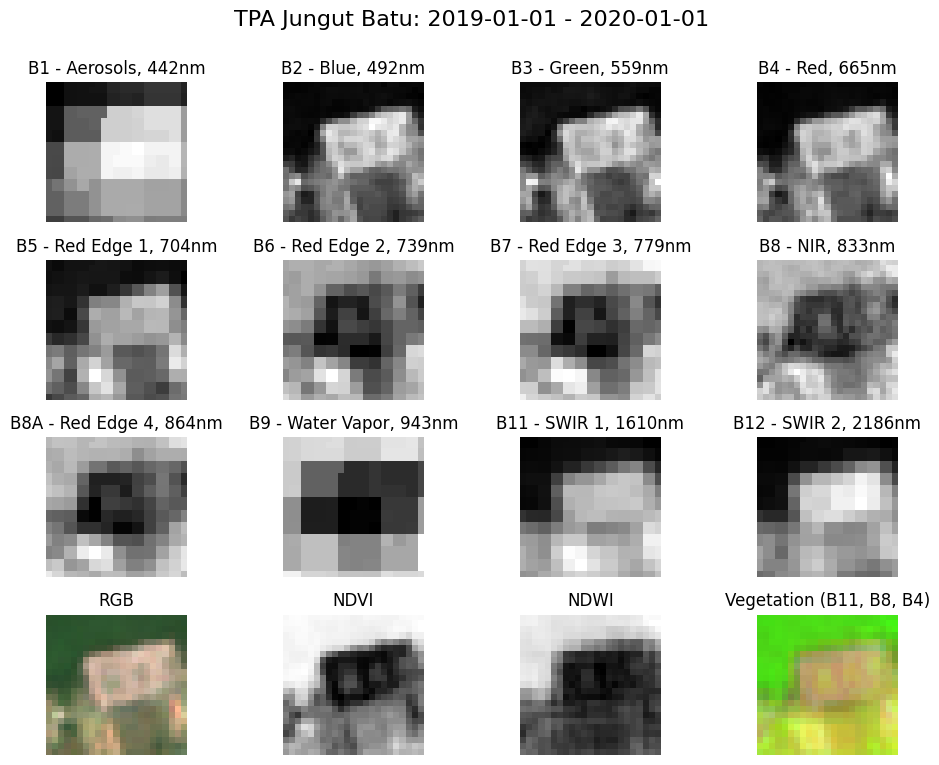

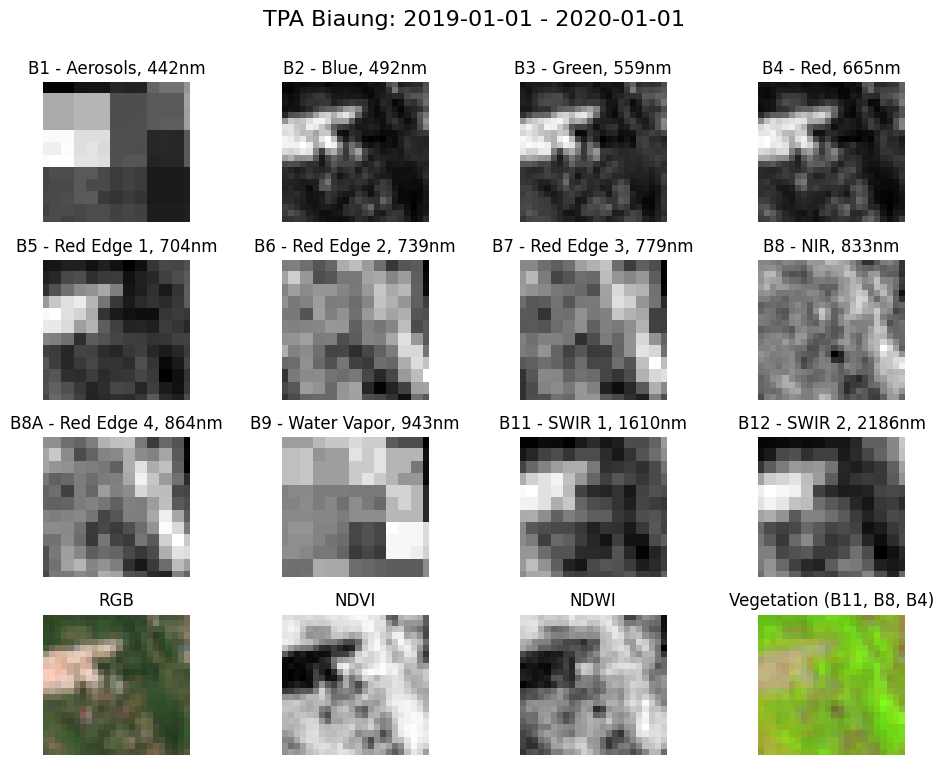

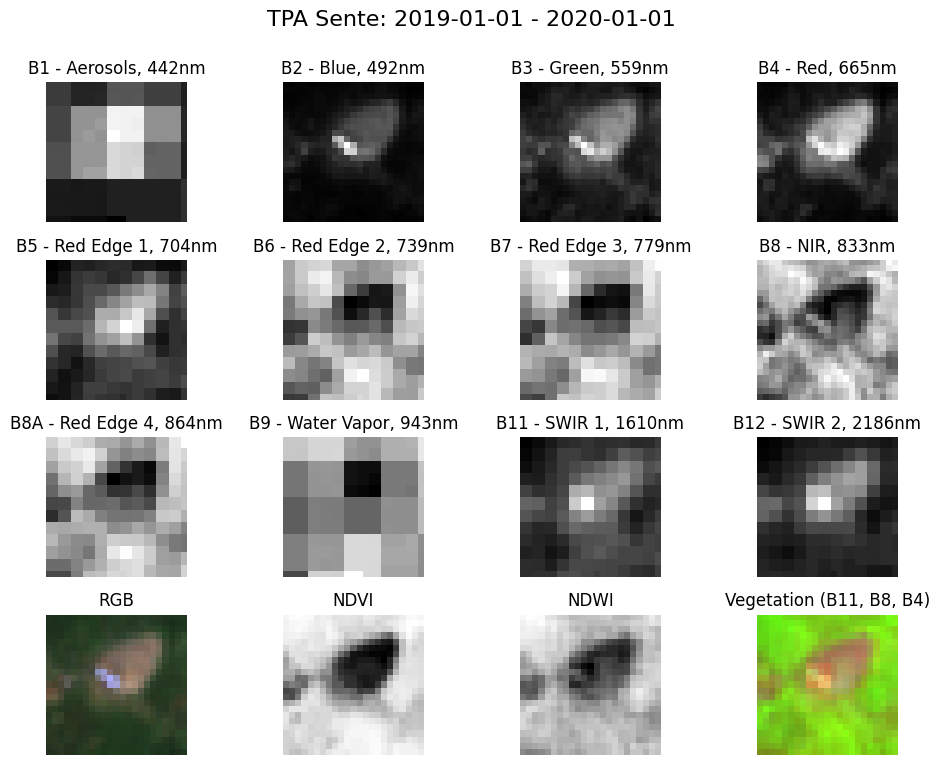

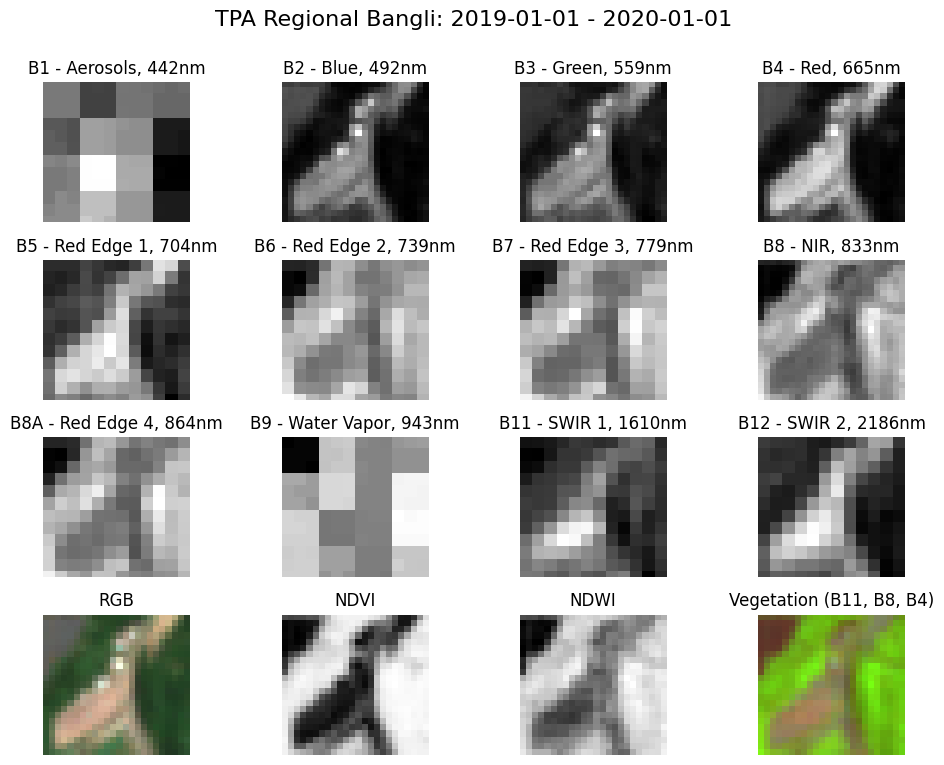

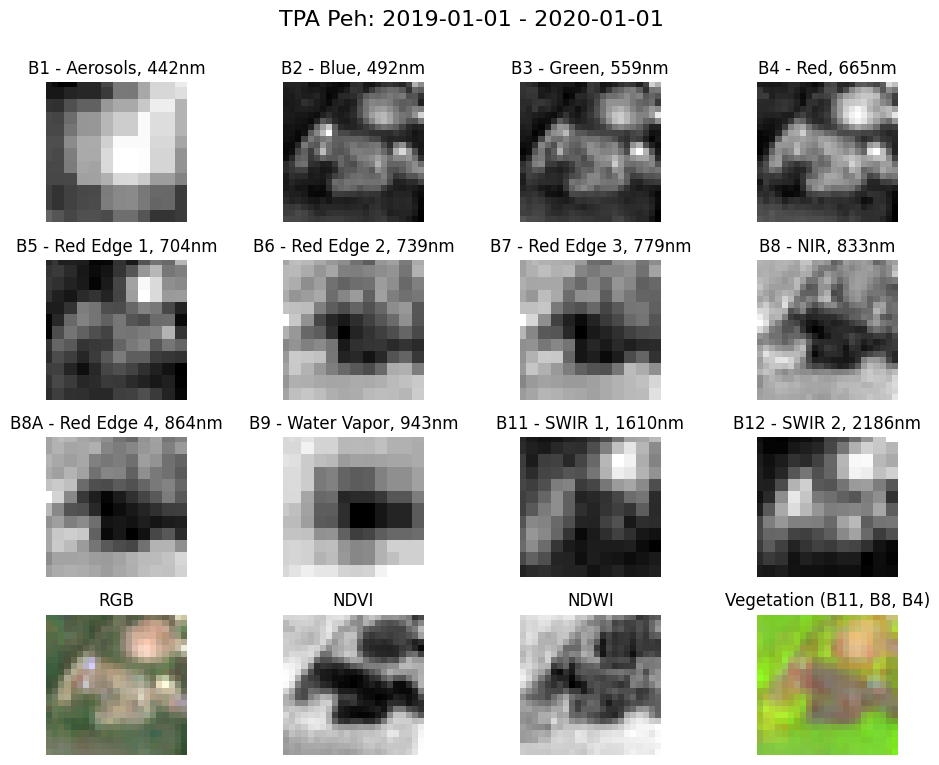

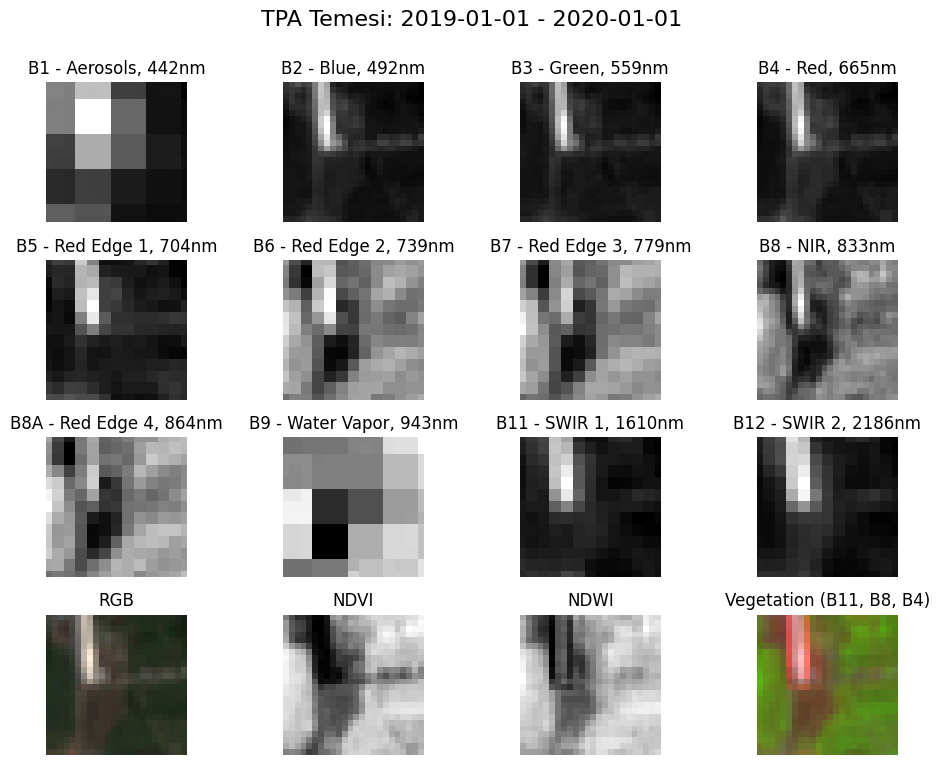

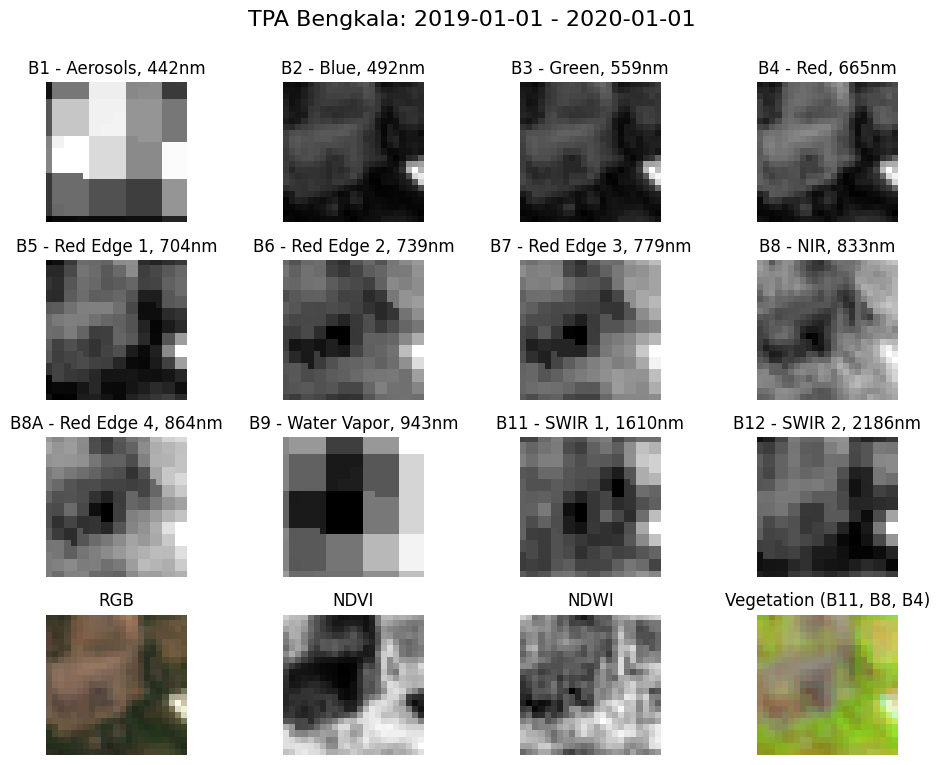

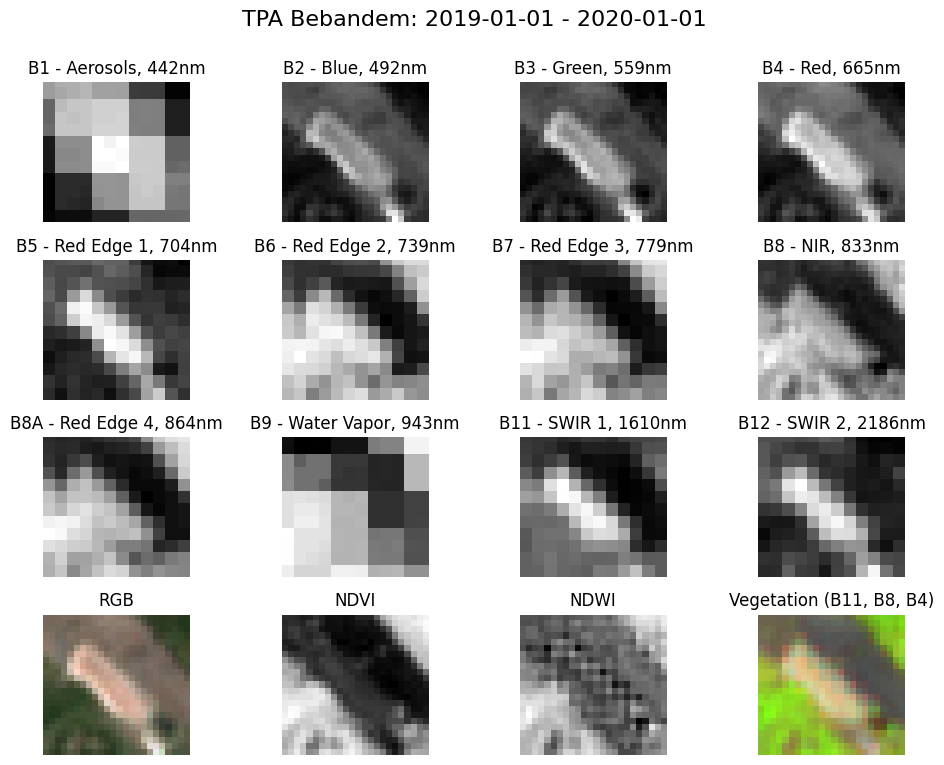

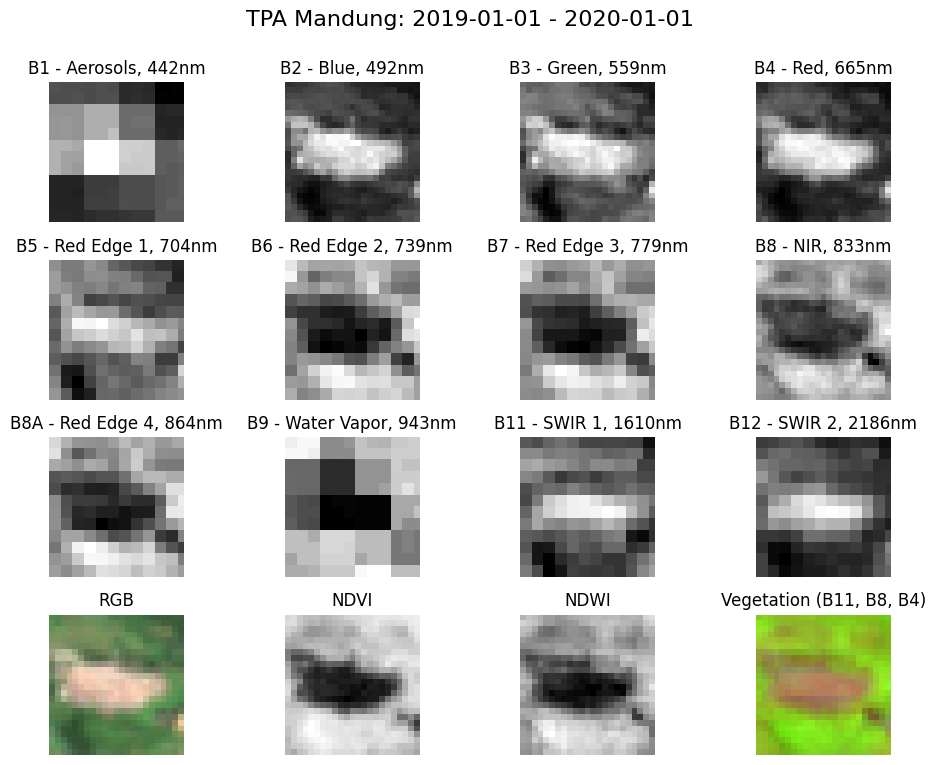

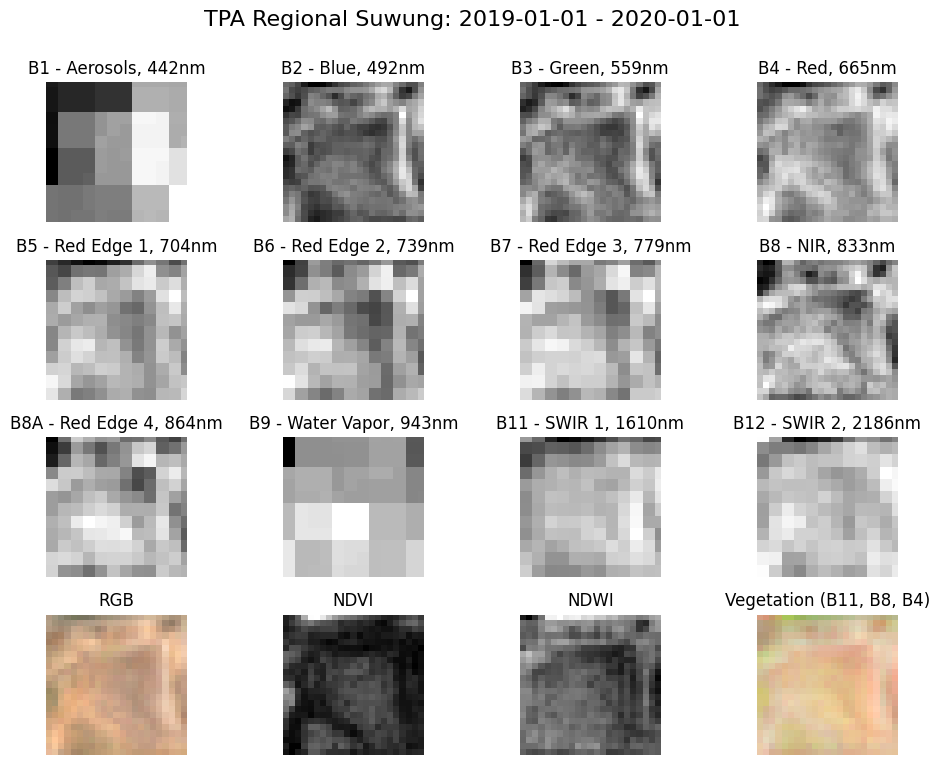

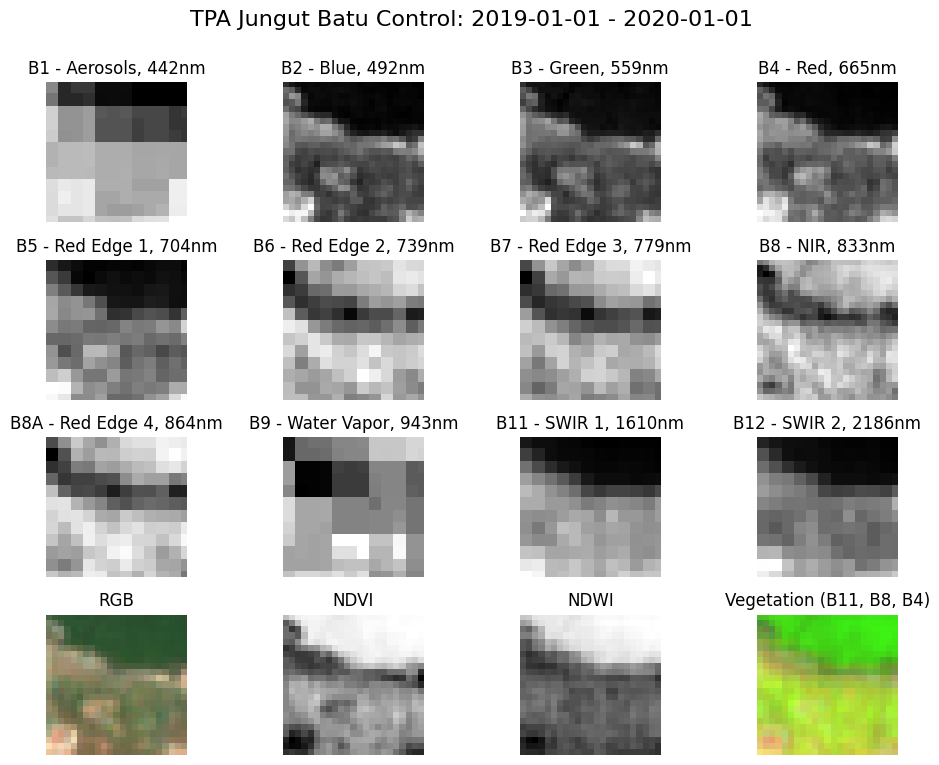

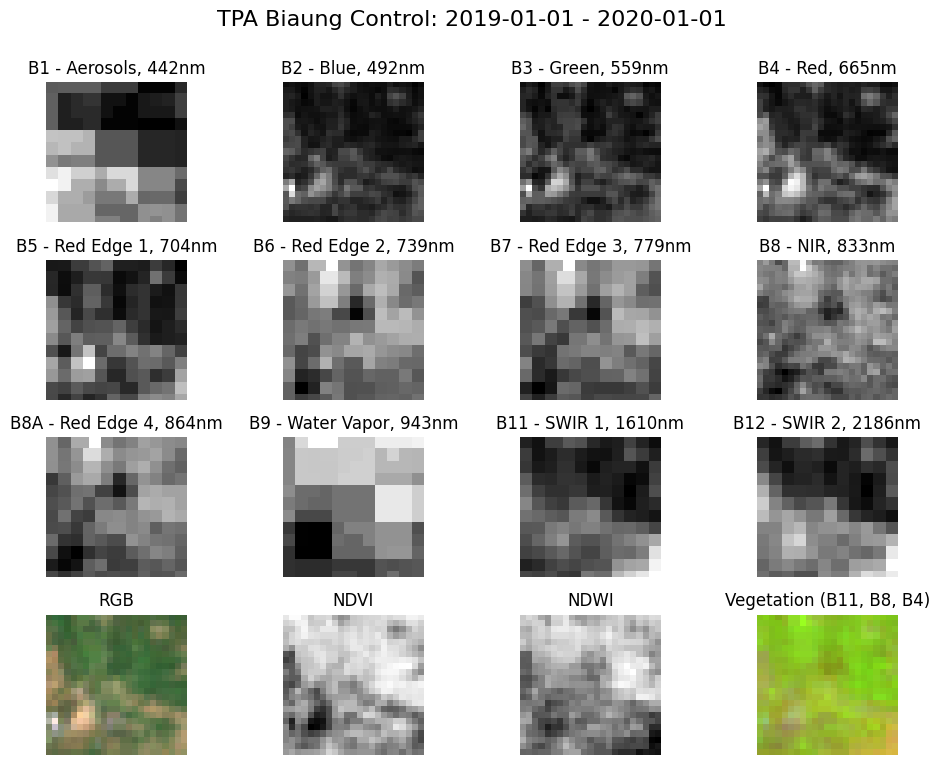

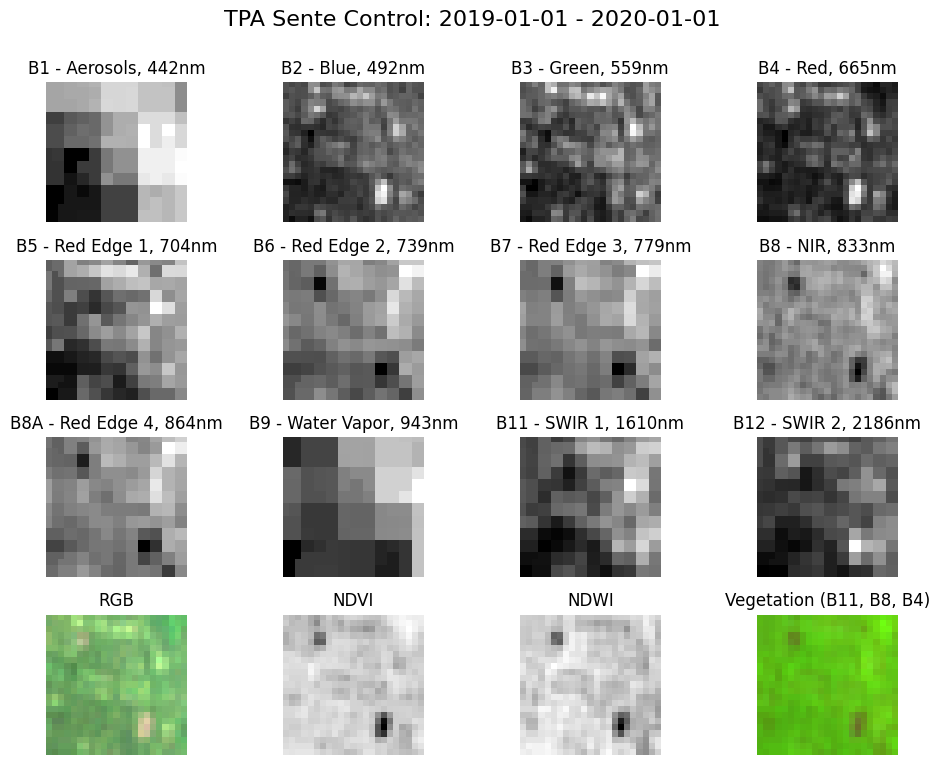

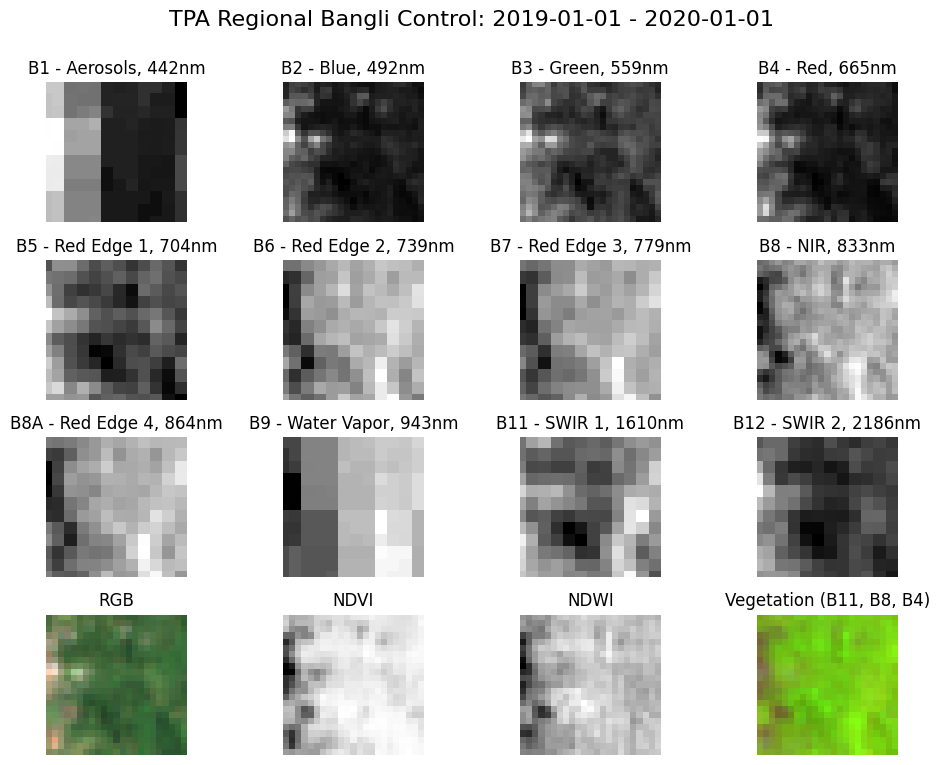

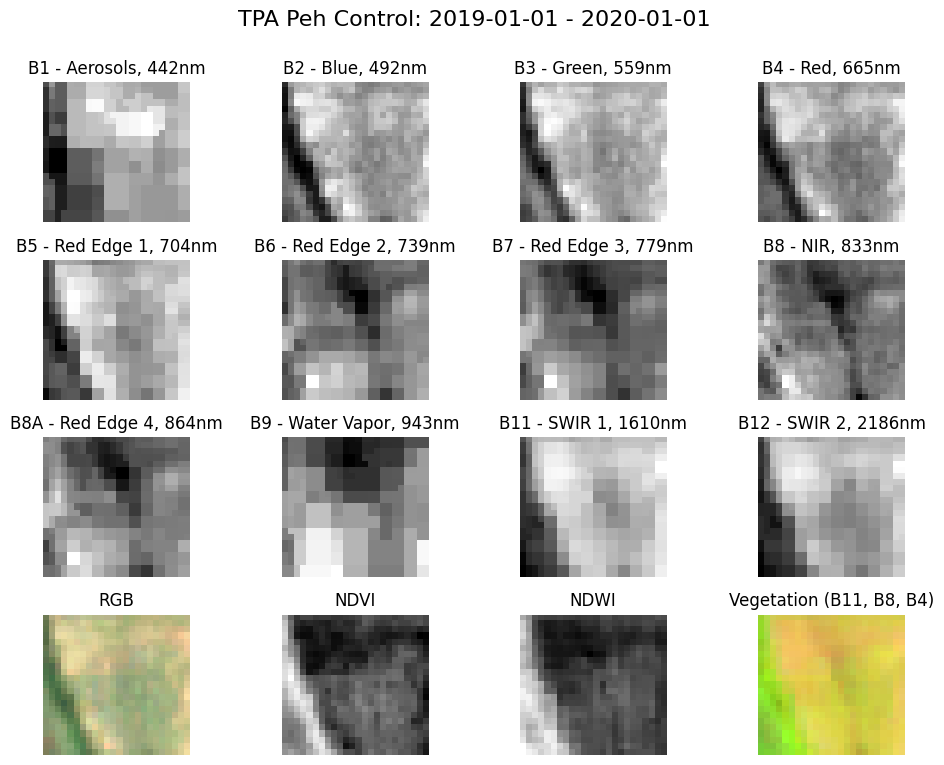

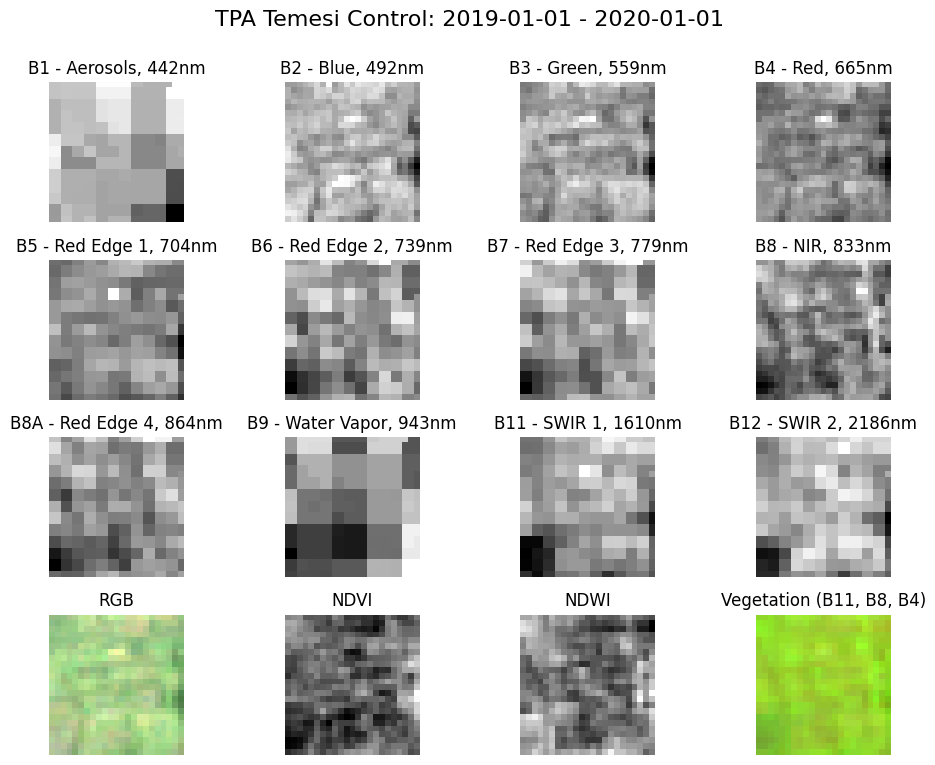

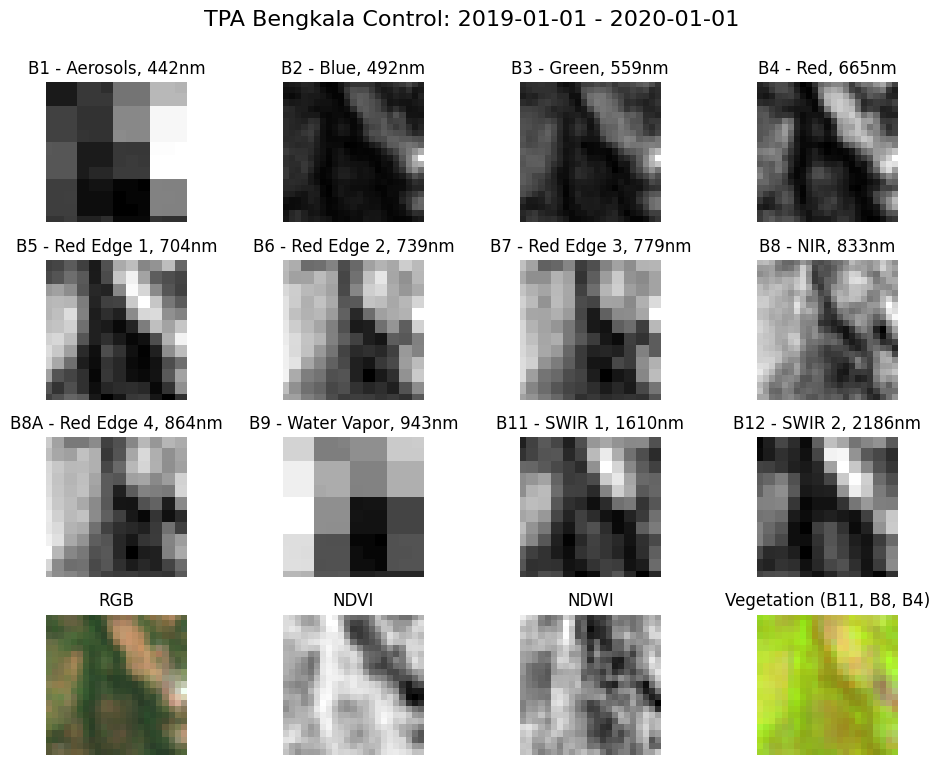

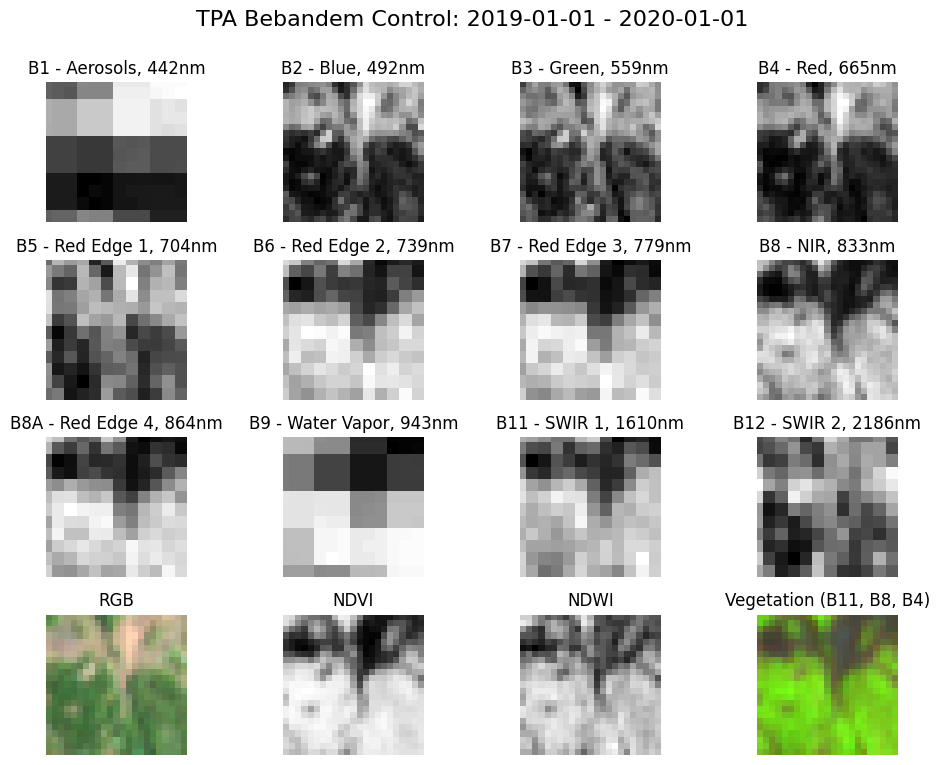

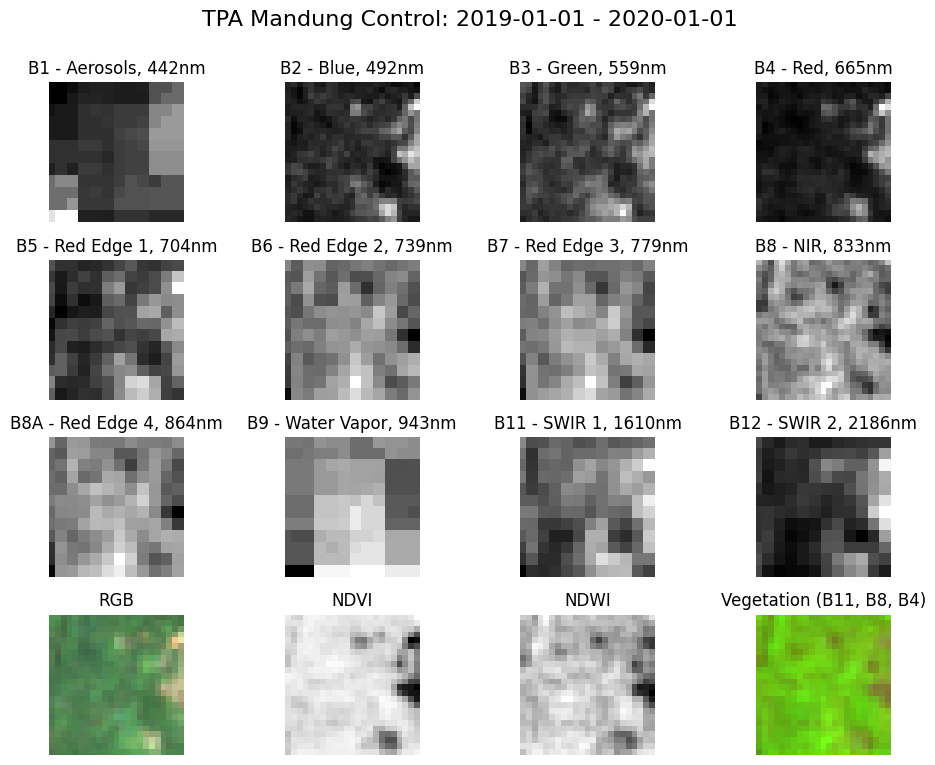

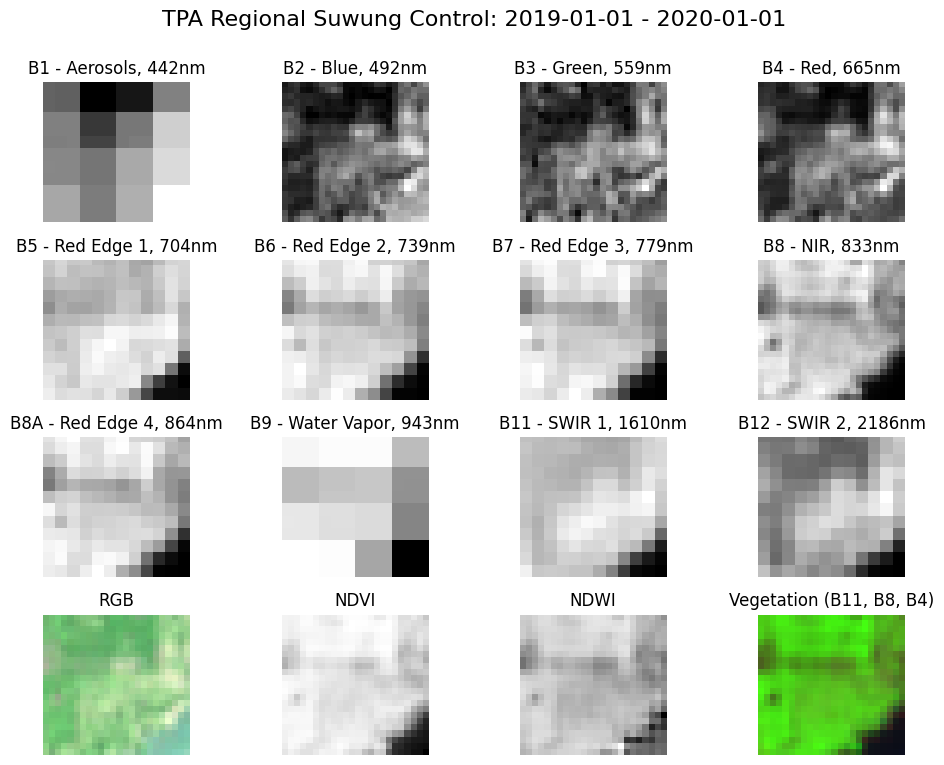

In [21]:
# Plot Patches
output_dir = './figures/patches'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

plot_patches(tpa_patches, output_dir)
plot_patches(control_patches, output_dir)


## Exploration 2
### Compare patch reflectance between TPA and control sites

In [22]:
def compute_stats(image_dict):
    stats = {}
    for band in list(band_descriptions):
        mean_values = [np.mean(image_dict[location][band]) for location in image_dict]
        stats[band] = {
            'mean': np.mean(mean_values),
            'median': np.median(mean_values),
            'std': np.std(mean_values)
        } 
    return stats

In [23]:
tpa_stats = compute_stats(tpa_patches)
control_stats = compute_stats(control_patches)

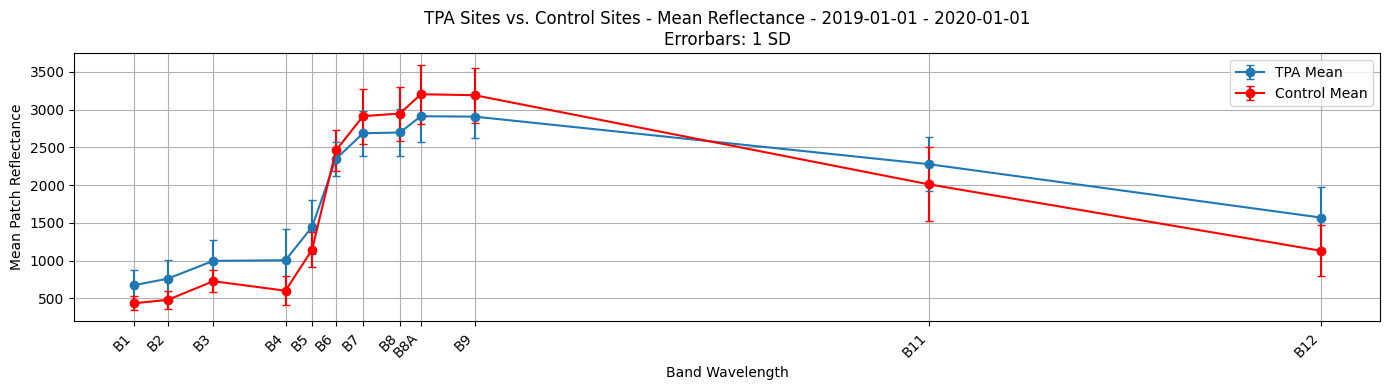

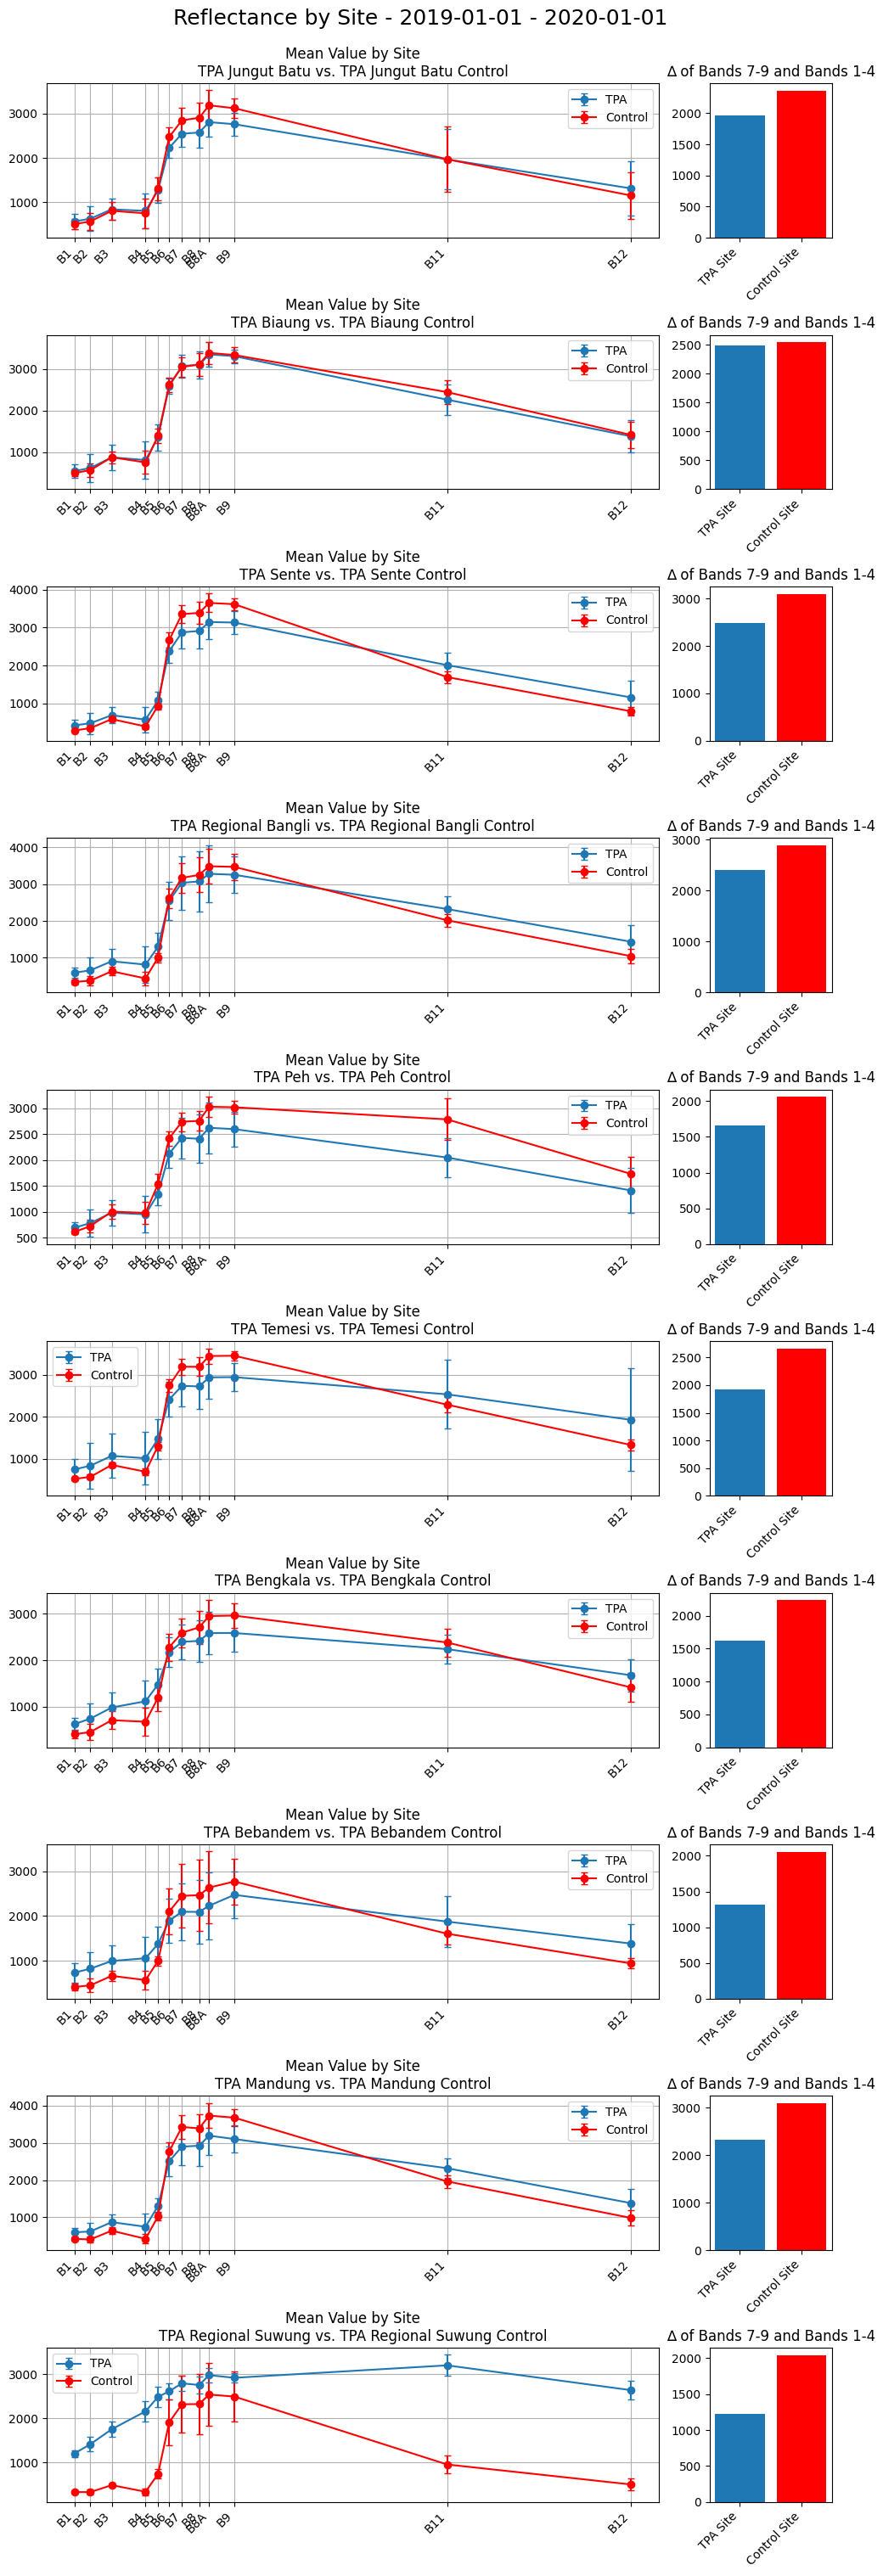

In [24]:
output_dir = './figures/reflectance'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

plt.figure(figsize=(14,4), dpi=100, facecolor=(1,1,1))
plt.errorbar(band_wavelengths, 
             [tpa_stats[band]['mean'] for band in tpa_stats],
             [tpa_stats[band]['std'] for band in tpa_stats],
             fmt='o-', capsize=3, label='TPA Mean')

plt.errorbar(band_wavelengths, 
             [control_stats[band]['mean'] for band in control_stats], 
             [control_stats[band]['std'] for band in control_stats], 
             fmt='o-', capsize=3, c='r', label='Control Mean')

#plt.plot([tpa_stats[band]['median'] for band in tpa_stats], label='TPA Median')
#plt.plot([control_stats[band]['median'] for band in control_stats], c='r', label='Control Median')
plt.xticks(band_wavelengths, list(tpa_stats), rotation=45, ha='right')
plt.grid()
plt.xlabel('Band Wavelength')
plt.ylabel('Mean Patch Reflectance')
plt.ylim([200, 3750])
plt.legend()
plt.title(f"TPA Sites vs. Control Sites - Mean Reflectance - {start} - {end}\nErrorbars: 1 SD")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, f"TPA Sites vs. Control Sites - Mean Reflectance - {start} - {end}.png"))
plt.show()

fig = plt.subplots(len(tpa_patches), 2, figsize=(10,3 * len(tpa_patches)), dpi=100, facecolor=(1,1,1))
grid = gridspec.GridSpec(len(tpa_patches), 2, width_ratios=[5, 1])
for index, (tpa_site, control_site) in enumerate(zip(tpa_patches, control_patches)):
    tpa_mean = []
    tpa_std = []
    control_mean = []
    control_std = []
    for band in list(band_descriptions):
        tpa_mean.append(np.mean(tpa_patches[tpa_site][band]))
        tpa_std.append(np.std(tpa_patches[tpa_site][band]))
        control_mean.append(np.mean(control_patches[control_site][band]))
        control_std.append(np.std(control_patches[control_site][band]))
    ax0 = plt.subplot(grid[index, 0])
    ax0.errorbar(band_wavelengths, tpa_mean, tpa_std, fmt='o-', capsize=3, label='TPA')
    ax0.errorbar(band_wavelengths, control_mean, control_std, fmt='o-', c='r', capsize=3, label='Control')
    ax0.legend()
    ax0.set_xticks(band_wavelengths)
    ax0.set_xticklabels(list(tpa_stats), rotation=45, ha='right')
    ax0.set_title(f"Mean Value by Site\n{tpa_site} vs. {control_site}")
    ax0.grid()

    ax1 = plt.subplot(grid[index, 1])
    ax1.bar([0], [np.mean(tpa_mean[6:10]) - np.mean(tpa_mean[:4])])
    ax1.bar([1], [np.mean(control_mean[6:10]) - np.mean(control_mean[:4])], color='r')
    ax1.set_title("∆ of Bands 7-9 and Bands 1-4")
    ax1.set_xticks([0, 1])
    ax1.set_xticklabels(['TPA Site', 'Control Site'], rotation=45, ha='right')
plt.tight_layout()
plt.suptitle(f"Reflectance by Site - {start} - {end}", size=18, y=1.01)
plt.savefig(os.path.join(output_dir, f"Reflectance by Site - {start} - {end}.png"))
plt.show()

## Exploration 3
### Temporal Monitoring

### Compile a dictionary of patches across a time period
History dictionary structure: `{dates: {sites: {bands: patch}`

Note: I can't access Sentinel data older than 2019 using earth engine. I'm not sure why.

In [25]:
tpa_history = {}
control_history = {}

start = '2019-01-01'
num_months = 12

date = ee.Date(start)
for month in tqdm(range(num_months)):
    s2_data = get_s2_sr_cld_col(bali_rect, date, date.advance(1, 'month'))
    s2_sr_median = s2_data.filterBounds(bali_rect) \
                        .map(add_cld_shdw_mask) \
                        .map(apply_cld_shdw_mask) \
                        .median() \
                        .clip(bali_rect)

    tpa_patches = get_patches(tpa_sites['name'], tpa_sites['coords'], RECT_WIDTH, s2_sr_median)
    control_patches = get_patches(control_sites['name'], control_sites['coords'], RECT_WIDTH, s2_sr_median)
    
    date_text = str(datetime.fromtimestamp(date.getInfo()['value'] // 1000 + 86400).date())
    tpa_history[date_text] = tpa_patches
    control_history[date_text] = control_patches
    
    date = date.advance(1, 'month')


Processing TPA Jungut Batu
Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B4' with no default value set. Note that calling sampleRectangle() on an image after ee.Image.clip() may result in a sampling bounding box outside the geometry passed to clip().
Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B11' with no default value set. Note that calling sampleRectangle() on an image after ee.Image.clip() may result in a sampling bounding box outside the geometry passed to clip().Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B8A' with no default value set. Note that calling sampleRectangle() on an image after ee.Image.clip() may result in a sampling bounding box outside the geometry passed to clip().

Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B3' with no default value

Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B5' with no default value set. Note that calling sampleRectangle() on an image after ee.Image.clip() may result in a sampling bounding box outside the geometry passed to clip().
Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B1' with no default value set. Note that calling sampleRectangle() on an image after ee.Image.clip() may result in a sampling bounding box outside the geometry passed to clip().
Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B2' with no default value set. Note that calling sampleRectangle() on an image after ee.Image.clip() may result in a sampling bounding box outside the geometry passed to clip().Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B4' with no default value set. Note that calling sample

Processing TPA Temesi Control
Processing TPA Bengkala Control
Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B9' with no default value set. Note that calling sampleRectangle() on an image after ee.Image.clip() may result in a sampling bounding box outside the geometry passed to clip().
Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B7' with no default value set. Note that calling sampleRectangle() on an image after ee.Image.clip() may result in a sampling bounding box outside the geometry passed to clip().
Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B6' with no default value set. Note that calling sampleRectangle() on an image after ee.Image.clip() may result in a sampling bounding box outside the geometry passed to clip().
Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when samplin

Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B2' with no default value set. Note that calling sampleRectangle() on an image after ee.Image.clip() may result in a sampling bounding box outside the geometry passed to clip().
Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B5' with no default value set. Note that calling sampleRectangle() on an image after ee.Image.clip() may result in a sampling bounding box outside the geometry passed to clip().
Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B9' with no default value set. Note that calling sampleRectangle() on an image after ee.Image.clip() may result in a sampling bounding box outside the geometry passed to clip().
Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B8' with no default value set. Note that calling sampl

Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B6' with no default value set. Note that calling sampleRectangle() on an image after ee.Image.clip() may result in a sampling bounding box outside the geometry passed to clip().
Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B8A' with no default value set. Note that calling sampleRectangle() on an image after ee.Image.clip() may result in a sampling bounding box outside the geometry passed to clip().
Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B7' with no default value set. Note that calling sampleRectangle() on an image after ee.Image.clip() may result in a sampling bounding box outside the geometry passed to clip().
Processing TPA Regional Bangli
Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B2' with no default va

Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B8' with no default value set. Note that calling sampleRectangle() on an image after ee.Image.clip() may result in a sampling bounding box outside the geometry passed to clip().
Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B7' with no default value set. Note that calling sampleRectangle() on an image after ee.Image.clip() may result in a sampling bounding box outside the geometry passed to clip().Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B12' with no default value set. Note that calling sampleRectangle() on an image after ee.Image.clip() may result in a sampling bounding box outside the geometry passed to clip().
Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B1' with no default value set. Note that calling sampl

Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B5' with no default value set. Note that calling sampleRectangle() on an image after ee.Image.clip() may result in a sampling bounding box outside the geometry passed to clip().
Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B8A' with no default value set. Note that calling sampleRectangle() on an image after ee.Image.clip() may result in a sampling bounding box outside the geometry passed to clip().
Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B11' with no default value set. Note that calling sampleRectangle() on an image after ee.Image.clip() may result in a sampling bounding box outside the geometry passed to clip().
Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B1' with no default value set. Note that calling sam

Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B1' with no default value set. Note that calling sampleRectangle() on an image after ee.Image.clip() may result in a sampling bounding box outside the geometry passed to clip().
Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B2' with no default value set. Note that calling sampleRectangle() on an image after ee.Image.clip() may result in a sampling bounding box outside the geometry passed to clip().
Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B5' with no default value set. Note that calling sampleRectangle() on an image after ee.Image.clip() may result in a sampling bounding box outside the geometry passed to clip().
Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B4' with no default value set. Note that calling sampl

Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B12' with no default value set. Note that calling sampleRectangle() on an image after ee.Image.clip() may result in a sampling bounding box outside the geometry passed to clip().Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B6' with no default value set. Note that calling sampleRectangle() on an image after ee.Image.clip() may result in a sampling bounding box outside the geometry passed to clip().

Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B8' with no default value set. Note that calling sampleRectangle() on an image after ee.Image.clip() may result in a sampling bounding box outside the geometry passed to clip().
Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B3' with no default value set. Note that calling samp

Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B1' with no default value set. Note that calling sampleRectangle() on an image after ee.Image.clip() may result in a sampling bounding box outside the geometry passed to clip().
Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B7' with no default value set. Note that calling sampleRectangle() on an image after ee.Image.clip() may result in a sampling bounding box outside the geometry passed to clip().
Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B2' with no default value set. Note that calling sampleRectangle() on an image after ee.Image.clip() may result in a sampling bounding box outside the geometry passed to clip().
Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when

Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B8A' with no default value set. Note that calling sampleRectangle() on an image after ee.Image.clip() may result in a sampling bounding box outside the geometry passed to clip().
Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B5' with no default value set. Note that calling sampleRectangle() on an image after ee.Image.clip() may result in a sampling bounding box outside the geometry passed to clip().
Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B11' with no default value set. Note that calling sampleRectangle() on an image after ee.Image.clip() may result in a sampling bounding box outside the geometry passed to clip().
Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B3' with no default value set. Note that calling sam

Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B6' with no default value set. Note that calling sampleRectangle() on an image after ee.Image.clip() may result in a sampling bounding box outside the geometry passed to clip().
Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B2' with no default value set. Note that calling sampleRectangle() on an image after ee.Image.clip() may result in a sampling bounding box outside the geometry passed to clip().
Processing TPA Regional Suwung Control
Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung
Processing TPA Jungut Batu Control
Processing TPA Biaung Control
Processing TPA Sente Control
Processing TPA Regional Bangli Control
Processing TPA Peh Con

Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B12' with no default value set. Note that calling sampleRectangle() on an image after ee.Image.clip() may result in a sampling bounding box outside the geometry passed to clip().
Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B9' with no default value set. Note that calling sampleRectangle() on an image after ee.Image.clip() may result in a sampling bounding box outside the geometry passed to clip().
Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B4' with no default value set. Note that calling sampleRectangle() on an image after ee.Image.clip() may result in a sampling bounding box outside the geometry passed to clip().
Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B6' with no default value set. Note that calling samp

### Visualize time series by site

In [51]:
output_dir = './figures/time_series'
if not os.path.exists(output_dir):
        os.mkdir(output_dir)

for tpa_site, control_site in zip(tpa_sites['name'], control_sites['name']):
    plt.figure(figsize=(12,12), dpi=100, facecolor=(1,1,1))
    for index, band in enumerate(band_descriptions):
        tpa_means = []
        control_means = []
        for month in tpa_history.keys():
            if len(tpa_history[month][tpa_site][band]) > 0:
                tpa_means.append(np.mean(tpa_history[month][tpa_site][band]))
            else: 
                tpa_means.append(None)
                
            if len(control_history[month][control_site][band]) > 0:
                control_means.append(np.mean(control_history[month][control_site][band]))
            else: 
                control_means.append(None)
            
        plt.subplot(4, 3, index + 1)
        plt.plot(list(tpa_history.keys()), tpa_means, '-o', label='TPA Site')
        plt.plot(list(control_history.keys()), control_means, '-o', c='r', label='Control Site')
        plt.xticks(rotation=45, ha='right')
        plt.ylim([0, 4500])
        plt.legend()
        plt.title(f'Band {band}')
    plt.tight_layout()
    plt.suptitle(tpa_site, y=1.02, size=16)
    plt.savefig(os.path.join(output_dir, f'{tpa_site} time series.png'), bbox_inches='tight')
    plt.close()

## Exploration 4
### Spectral Clustering

For each site, compile a vector of mean band reflectance values for each month in the record from Exploration #3. Reduce dimensionality of each point from the number of bands to 2 using PCA and plot the 2D points.

In [48]:
output_dir = './figures/clustering'
if not os.path.exists(output_dir):
        os.mkdir(output_dir)

all_tpa_vectors = []
all_control_vectors = []
for tpa_site, control_site in zip(tpa_sites['name'], control_sites['name']):
    tpa_site_vectors = []
    control_site_vectors = []
    for month in tpa_history.keys():
        tpa_means = []
        control_means = []
        for index, band in enumerate(band_descriptions):
            if len(tpa_history[month][tpa_site][band]) > 0:
                tpa_means.append(np.mean(tpa_history[month][tpa_site][band]))
            if len(control_history[month][control_site][band]) > 0:
                control_means.append(np.mean(control_history[month][control_site][band]))
                
        if len(tpa_means) > 0:
            tpa_site_vectors.append(tpa_means)
            all_tpa_vectors.append(tpa_means)
        if len(control_means) > 0:
            control_site_vectors.append(control_means)
            all_control_vectors.append(control_means)
    
    pca = PCA(n_components=2)
    pca.fit(tpa_site_vectors)
    tpa_pca = pca.transform(tpa_site_vectors)
    control_pca = pca.transform(control_site_vectors)
    plt.figure(figsize=(8,5), dpi=100)
    plt.scatter(tpa_pca[:,0], tpa_pca[:,1], label='TPA')
    plt.scatter(control_pca[:,0], control_pca[:,1], c='r', label='Control')
    plt.title(tpa_site)
    plt.legend()
    plt.savefig(os.path.join(output_dir, f"{tpa_site} reflectance scatter PCA.png"))
    plt.close()

pca = PCA(n_components=2)
pca.fit(all_tpa_vectors)
tpa_pca = pca.transform(all_tpa_vectors)
control_pca = pca.transform(all_control_vectors)

plt.figure(figsize=(8,5), dpi=100)
plt.scatter(tpa_pca[:,0], tpa_pca[:,1], label='TPA')
plt.scatter(control_pca[:,0], control_pca[:,1], c='r', label='Control')
plt.legend()
plt.title('All Sites')
plt.savefig(os.path.join(output_dir, f"All sites reflectance scatter PCA.png"))
plt.close()